<a href="https://colab.research.google.com/github/kellytdunn/Seattle-parks/blob/master/Trail_Usage_Analysis_shareable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## How can I Avoid Crowds at Seattle Parks?

## Introduction

For my first Python project, I was curious how the pandemic was affecting transportation, as I am a transportation planner. I have gone out to exercise every day during the stay at home orders, and have observed many others doing the same, particularly at big city parks, like Myrtle Edwards. The City took notice and closed down some parks temporarily that were getting too crowded to allow for social distancing. I wondered if people were more likely to be in parks these days given that there are so few other places to be. 

## Housekeeping

*Note: This notebook uses two API tokens that I want to keep private while I share the notebook publicly. I define them here in a cell that i can easily hide before sharing. If you want to run these notebooks you'll need to grab your own token.Tokens for bike/ped data can be found here: https://data.seattle.gov/login. Tokens for NOAA data can be found here: https://www.ncdc.noaa.gov/cdo-web/token *

First, I import libraries:

In [ ]:
!pip install sodapy
!pip install seaborn
!pip install folium

In [ ]:
import sys
!{sys.executable} -m pip install ipywidgets>=7.5
import pandas as pd
from plotly.offline import iplot
import plotly.graph_objs as go
import time
import datetime
from datetime import date
import math
import requests
from sodapy import Socrata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
%matplotlib inline 
import scipy
from scipy import stats
import folium

## Defining my Approach and Data Requirements

This being my first project, I started out not entirely knowing what I would find, but I was interested in building a predictive model to help predict how crowded a park would be on a given day. To start off, I just wanted to understand the data.

I found a dataset from the Seattle Department of Transportation on bicycle and pedestrian counts from 2014-2020 at a specific point at Myrtle Edwards Park: https://data.seattle.gov/Transportation/Elliott-Bay-Trail-in-Myrtle-Edwards-Park-Bicycle-a/4qej-qvrz. 
I decided to use this count data as a proxy for how many people were using this park on a given day. Perhaps I will expand to other parks later, but for now, I'll stick with this park because I spent a lot of time there early in the pandemic.

First, because I like maps, here's Myrtle Edwards Park in context. You can zoom in and out. 

In [ ]:
folium.Map(location = [47.62, -122.36], zoom_start = 15)

I start the data analysis by accessing the API:

In [ ]:
#bike/ped count dataset
client = Socrata("data.seattle.gov",
                  SEA_token)

# returned as JSON from API / converted to Python list of dictionaries by sodapy.
results = client.get("4qej-qvrz", limit = 100000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

results_df.head()


,date,eilliott_bay_trail_in_myrtle_edwards_park_total,ped_north,ped_south,bike_north,bike_south
0,2020-06-01T00:00:00.000,5,2,1,1,1
1,2020-06-01T01:00:00.000,0,0,0,0,0
2,2020-06-01T02:00:00.000,1,0,0,1,0
3,2020-06-01T03:00:00.000,1,1,0,0,0
4,2020-06-01T04:00:00.000,1,0,0,1,0


Already, I can see some ways that this dataset can be improved. Thus begins the process of preparing the data.

## Data Preparation

In [ ]:
results_df['date']=pd.to_datetime(results_df['date'])

In [ ]:
(results_df['date']).dtype

dtype('<M8[ns]')

In [ ]:
#convert the datetime field in the "date" column to something more readable and separate date and time.
results_df['Date'] = pd.to_datetime(results_df['date']).dt.date 
results_df['Time'] = pd.to_datetime(results_df['date']).dt.time 
results_df.head()

,date,eilliott_bay_trail_in_myrtle_edwards_park_total,ped_north,ped_south,bike_north,bike_south,Date,Time
0,2020-06-01 00:00:00,5,2,1,1,1,2020-06-01,00:00:00
1,2020-06-01 01:00:00,0,0,0,0,0,2020-06-01,01:00:00
2,2020-06-01 02:00:00,1,0,0,1,0,2020-06-01,02:00:00
3,2020-06-01 03:00:00,1,1,0,0,0,2020-06-01,03:00:00
4,2020-06-01 04:00:00,1,0,0,1,0,2020-06-01,04:00:00


In [ ]:
#rename columns and add columns to help with data analysis.
clean_df = results_df.rename(columns={"date": "Timestamp_Date", "eilliott_bay_trail_in_myrtle_edwards_park_total": "Total"})
clean_df['Day of Week'] = pd.DatetimeIndex(clean_df['Date']).day_name() # week day name
clean_df['Month'] = pd.DatetimeIndex(clean_df['Date']).month_name() # month name
clean_df['Year'] = pd.DatetimeIndex(clean_df['Timestamp_Date']).year # year name
clean_df.head()


,Timestamp_Date,Total,ped_north,ped_south,bike_north,bike_south,Date,Time,Day of Week,Month,Year
0,2020-06-01 00:00:00,5,2,1,1,1,2020-06-01,00:00:00,Monday,June,2020
1,2020-06-01 01:00:00,0,0,0,0,0,2020-06-01,01:00:00,Monday,June,2020
2,2020-06-01 02:00:00,1,0,0,1,0,2020-06-01,02:00:00,Monday,June,2020
3,2020-06-01 03:00:00,1,1,0,0,0,2020-06-01,03:00:00,Monday,June,2020
4,2020-06-01 04:00:00,1,0,0,1,0,2020-06-01,04:00:00,Monday,June,2020


In [ ]:
APIrecords = clean_df.to_dict('records')

In [ ]:
len(results_df)

64992

So ```APIrecords``` is a list of dictionaries. Each dictionary represents one hour's worth of data and thus each dictionary has the same keys and different values. There are over 56,000 records in this dataset as of May 2020. As I play around with different functions, I need a quick way to select a subset of records so that every function doesn't iterate through the whole thing.

I create the below ```testlist``` to give myself a small section of the dataset to try out functions on. 

In [ ]:
testlist = APIrecords[:5]
testlist

[{'Date': datetime.date(2020, 6, 1),
  'Day of Week': 'Monday',
  'Month': 'June',
  'Time': datetime.time(0, 0),
  'Timestamp_Date': Timestamp('2020-06-01 00:00:00'),
  'Total': '5',
  'Year': 2020,
  'bike_north': '1',
  'bike_south': '1',
  'ped_north': '2',
  'ped_south': '1'},
 {'Date': datetime.date(2020, 6, 1),
  'Day of Week': 'Monday',
  'Month': 'June',
  'Time': datetime.time(1, 0),
  'Timestamp_Date': Timestamp('2020-06-01 01:00:00'),
  'Total': '0',
  'Year': 2020,
  'bike_north': '0',
  'bike_south': '0',
  'ped_north': '0',
  'ped_south': '0'},
 {'Date': datetime.date(2020, 6, 1),
  'Day of Week': 'Monday',
  'Month': 'June',
  'Time': datetime.time(2, 0),
  'Timestamp_Date': Timestamp('2020-06-01 02:00:00'),
  'Total': '1',
  'Year': 2020,
  'bike_north': '1',
  'bike_south': '0',
  'ped_north': '0',
  'ped_south': '0'},
 {'Date': datetime.date(2020, 6, 1),
  'Day of Week': 'Monday',
  'Month': 'June',
  'Time': datetime.time(3, 0),
  'Timestamp_Date': Timestamp('2020-0

### Creating Functions to Prepare the Data

In [ ]:
def timestamp(mmddyyyy):
    return pd.to_datetime(mmddyyyy)

In [ ]:
def hourlycounts(date, data): #date must be entered as 'mm/dd/yy', including quotes
    target_date = timestamp(date) #this caches the function so it doesn't have to recalculate with every iteration. 
    return [x['Total'] for x in data if x['Date'] == target_date] #this is a cleaner list comprehension. Thank you Stack Overflow.


If I want to be able to create graphs with time or date as an independent variable, I need to be able to generate a list of all the values associated with a specific key in the list of dictionaries. Below, I create a function and test it out on ```testlist```.

In [ ]:
def list_from_dictionary(dictlist, key):
    return [sub[key] for sub in dictlist]
list_from_dictionary(testlist, 'Day of Week')

['Monday', 'Monday', 'Monday', 'Monday', 'Monday']

Trying this function out on ```testlist``` confirms that it would not filter out duplicates, and if I run this on the whole dataset it would return 54,000 items, which I don't want. 

To create a list of all the values for a given key, without duplicates, I need a new function. 

In [ ]:
#generate list of all unique values in a given column in the dataset. Use to generate x values for graphs and in for loops.
def unique(recordlist, key):
    new_list=[]
    list1 = list_from_dictionary(recordlist, key)
    list_set = set(list1)
    unique_list = list(list_set)
    for x in unique_list:
        new_list.append(x)
    return new_list
unique(testlist, 'Day of Week')

['Monday']

I apply this to the 'Time' key, as I plan to use hour of day as an x-value for my initial graphs.

In [ ]:
alltimes = sorted(unique(APIrecords, 'Time'))


Now I want to know how April 2020 overall compares to other years to see if, overall, April 2020 might see different usage than prior years. I'll choose Fridays in April as a way to compare apples to apples across different years.
To start with, the function below would give you, for example, the average count at noon for all the Fridays in April 2020. 

In [ ]:
def hourly_average_by_day(month, year, weekday, hour):
    monthly_total = []
    matching_records = list(record for record in APIrecords if record['Day of Week']==weekday and record['Month']==month and record['Time']==hour and record['Year']==year)
    for record in matching_records:
        monthly_total.append(int(record['Total']))
    try: 
        return sum(monthly_total)/len(monthly_total)
    except:
        return 'error'

#hourly_average_by_day('March', 2017, 'Friday', datetime.time(17, 0))


The function above gives me average counts for a specific hour of a specific weekday in the year and month I provide as arguments. Now I want to be able to apply that function to every year all at once, so I can graph it and see a change over time. Maybe people are using the park at different times of day than they used to, and I'm curious how that's changed. The following function applies ```hourly_average_by_day()``` to every year from 2014-2020.

First, though, I noticed when looking through the data that no counts were recorded for a large part of 2015; the equipment must have been broken. I don't want to get zeros in my plots, so I'm going to omit 2015 data. 

In [ ]:
def counts_across_years(month, weekday, hour): #note below how the hour must be formatted.
    counts_list=[]
    for year in [x for x in range(2014, 2021) if x != 2015]:
        count = hourly_average_by_day(month, year, weekday, hour)
        counts_list.append(count)
    return counts_list

#counts_across_years('April', 'Friday', datetime.time(12, 0))

In [ ]:
allyears=[]
for i in [x for x in range(2014, 2021) if x != 2015]:
    allyears.append(i)
allyears

[2014, 2016, 2017, 2018, 2019, 2020]

## Data Exploration

Now I want to start getting a sense of what's actually in this data, so I can determine how I want to analyze it.

### Graphing Trail Usage Over Time

Now it's time to make my first graph. I will use my ```counts_across_years()``` function to graph how average hourly counts at noon for any given weekday have changed from 2014-2020. I am curious if 2020 will continue past trends or show a departure. 

In [ ]:
width = 12
height = 10
plt.figure(figsize=(width, height))
fig = go.Figure()
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Monday', datetime.time(12, 0)),
                    mode='lines',
                    name='Mondays, 12-1 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Tuesday', datetime.time(12, 0)),
                    mode='lines',
                    name='Tuesdays, 12-1 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Wednesday', datetime.time(12, 0)),
                    mode='lines',
                    name='Wednesdays, 12-1 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Thursday', datetime.time(12, 0)),
                    mode='lines',
                    name='Thursdays, 12-1 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Friday', datetime.time(12, 0)),
                    mode='lines',
                    name='Fridays, 12-1 pm'))
fig.update_layout(title='Average Park Activity During Different Days of the Week in April, Lunchtime',
                   xaxis_title='Year',
                   yaxis_title='Average Bike + Ped Count')
fig.show()

<Figure size 864x720 with 0 Axes>

This data suggests that park usage on any given weekday in April 2020 is higher compared to the same weekday in 2019, except on Tuesdays, but compared to prior years there's no recognizable pattern. This is just the lunch hour though. Will this pattern hold after work hours?

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Monday', datetime.time(17, 0)),
                    mode='lines',
                    name='Mondays, 5-6 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Tuesday', datetime.time(17, 0)),
                    mode='lines',
                    name='Tuesdays, 5-6 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Wednesday', datetime.time(17, 0)),
                    mode='lines',
                    name='Wednesdays, 5-6 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Thursday', datetime.time(17, 0)),
                    mode='lines',
                    name='Thursdays, 5-6 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Friday', datetime.time(17, 0)),
                    mode='lines',
                    name='Fridays, 5-6 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Saturday', datetime.time(17, 0)),
                    mode='lines',
                    name='Saturdays, 5-6 pm'))

fig.update_layout(title='Average Park Activity During Different Days of the Week in March, Evenings',
                   xaxis_title='Year',
                   yaxis_title='Average Bike + Ped Count')
fig.show()

Interestingly, the same pattern doesn't hold from the 5 to 6 pm hour, at least not every day. While Tuesday and Wednesday afternoons see a steep drop from 2019, Thursday and Fridays see increases. But while in 2019 there was  noticeably higher usage earlier in the week, in 2020 usage is converging on all days except Monday. Perhaps the pandemic has wiped away most of the weekly rhythms that distinguish one weekday from another. 

Now I'd like to get a sense of how usage varies throughout the day. This could help people determine the least crowded time to visit the park, for example. The function below takes a month, year, and weekday (for example, Fridays in March 2020) and returns average counts for each hour: average counts at 10am, average counts at 11am, etc.

In [ ]:
def monthly_average_by_hour(month, year, weekday):
    hourly_average=[]
    hourlist = sorted(unique(APIrecords, 'Time'))
    for hour in hourlist:
        hourly_average.append(hourly_average_by_day(month, year, weekday, hour))
    return hourly_average
monthly_average_by_hour('April', 2020, 'Friday')
#it would be best if this were a dictionary so we could ensure keys and values are matched up.

[12.25,
 4.0,
 4.75,
 2.25,
 8.75,
 20.0,
 112.75,
 204.0,
 188.75,
 210.5,
 241.0,
 282.75,
 334.5,
 371.0,
 350.0,
 403.75,
 436.75,
 501.0,
 529.0,
 342.75,
 128.0,
 40.5,
 29.5,
 10.0]

That data looks about right, based on what I've observed on various of my own walks! Usage peaks in late afternoon when people get off work and it is warmer. For now I'm going to apply this function to different years in the dataset to compare trends year over year. But instead of Friday, I'll graph Wednesday, because in transportation terms you get a better picture of people's habits if you choose data in the middle of the week. 

In [ ]:
plt.figure(figsize=(width, height))
fig = go.Figure()
fig.add_trace(go.Scatter(x=alltimes, y=monthly_average_by_hour('April', 2020, 'Wednesday'),
                    mode='lines',
                    name='2020'))
fig.add_trace(go.Scatter(x=alltimes, y=monthly_average_by_hour('April', 2019, 'Wednesday'),
                    mode='lines',
                    name='2019'))
fig.add_trace(go.Scatter(x=alltimes, y=monthly_average_by_hour('April', 2018, 'Wednesday'),
                    mode='lines',
                    name='2018'))
fig.add_trace(go.Scatter(x=alltimes, y=monthly_average_by_hour('April', 2017, 'Wednesday'),
                    mode='lines',
                    name='2017'))
fig.add_trace(go.Scatter(x=alltimes, y=monthly_average_by_hour('April', 2016, 'Wednesday'),
                    mode='lines',
                    name='2016'))
fig.update_layout(title='Average Hourly Park Activity for Wednesdays in April',
                   xaxis_title='Hour of Day',
                   yaxis_title='Average Bike + Ped Count')
fig.show()

<Figure size 864x720 with 0 Axes>

So activity in April 2020 does not really stand out compared to other years.

So far we've been looking at April 2020 only as a whole. Let's zoom in on April 2020 by graphing hourly counts for every Friday that month. I posit that counts will creep up week after week, as more and more people began working from home and looking for ways to get some exercise during and after work.

In [ ]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=alltimes, y=hourlycounts('4/3/2020', APIrecords),
                    mode='lines',
                    name='April 3',
                    line_color='rgb(40, 246, 212)'),
                    secondary_y=False)
fig.add_trace(go.Scatter(x=alltimes, y=hourlycounts('4/10/2020', APIrecords),
                    mode='lines',
                    name='April 10',
                    line_color='rgb(27, 164, 161)'),
                    secondary_y=False)
fig.add_trace(go.Scatter(x=alltimes, y=hourlycounts('4/17/2020', APIrecords),
                    mode='lines',
                    name='April 17',
                    line_color='rgb(15, 82, 110)'),
                    secondary_y=False)
fig.add_trace(go.Scatter(x=alltimes, y=hourlycounts('4/24/2020', APIrecords),
                    mode='lines',
                    name='April 24',
                    line_color='rgb(3, 1, 60)'),
                    secondary_y=False)

fig.update_layout(title='Bike and Ped Activity in Myrtle Edwards Park - Fridays During Covid-19 (2020)',
                   xaxis_title='Hour of Day',
                   yaxis_title='Total Bike + Ped Count')
fig.show()

Well, I was wrong. Bicyle and pedestrian counts seem to vary quite a bit by day, and don't seem to be increasing over time. Could weather be a factor in day to day differences? Let's dig into some more data to find out.

### Investigating Weather Factors

In [ ]:
#x axis: weeks or days
#y axis: total count of the week
alldays = sorted(unique(APIrecords, 'Date')) #what is this for? not sure if sorting will matter once we have a df.

### Accessing Weather Data

I will use the Climate Data Online API from NOAA: https://www.ncdc.noaa.gov/cdo-web/webservices/v2#gettingStarted. It includes a dataset on historical high temperatures by day. 

I will also use the cdo-api-py library for this, which is a huge help. https://pypi.org/project/cdo-api-py/. With this library I don't have to worry about creating separate queries to get around request limits, or converting Celsius to Fahrenheit. 

In [ ]:
!pip install cdo_api_py
!pip install config

In [ ]:
from cdo_api_py import Client

# Utils
import config
import pandas as pd
from datetime import datetime
from pprint import pprint

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [ ]:
# Define the client

my_client = Client(NOAA_token, default_units='standard', default_limit=1000)

######################################
#           Configuration            #
######################################

# Select an area
extent = {
    "north": 47.9,
    "south": 47.3,
    "east": -122.26,
    "west": -122.68,
}

# Selected Dates
startdate = date(2014, 1, 1)
enddate = date.today()

# Datasets we will query
datasetid='GHCND'


# PRCP = Precipitation (mm or inches as per user preference, inches to hundredths on Daily Form pdf file)
# SNOW = Snowfall (mm or inches as per user preference, inches to tenths on Daily Form pdf file)
# TMAX = Maximum temperature (Fahrenheit or Celsius as per user preference, Fahrenheit to tenths on
# Daily From pdf file

# Data Types
datatypeid=['TMAX', 'PRCP', 'SNOW']

In [ ]:
# Find weather stations with data
stations = my_client.find_stations(
    datasetid=datasetid,
    extent=extent,
    startdate=startdate,
    enddate=enddate,
    datatypeid=datatypeid,
    return_dataframe=True)


# Create an empty dataframe to store climate data
climate_data = pd.DataFrame()

for rowid, station in stations.iterrows():  
    station_data = my_client.get_data_by_station(
        datasetid=datasetid,
        stationid=station['id'],
        startdate=startdate,
        enddate=enddate,
        return_dataframe=True,
        include_station_meta=True   # flatten station metadata with ghcnd readings
    )
    climate_data = pd.concat([climate_data, station_data])

https://www.ncdc.noaa.gov/cdo-web/api/v2/stations?datasetid=GHCND&startdate=2014-01-01&enddate=2021-07-04&extent=47.3&extent=-122.68&extent=47.9&extent=-122.26&datatypeid=TMAX&datatypeid=PRCP&datatypeid=SNOW&limit=1000&units=standard
https://www.ncdc.noaa.gov/cdo-web/api/v2/stations/GHCND:USW00024233?limit=1000&units=standard
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&startdate=2014-01-01&enddate=2015-01-01&stationid=GHCND:USW00024233&limit=1000&units=standard
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&startdate=2014-01-01&enddate=2015-01-01&stationid=GHCND:USW00024233&limit=1000&units=standard&offset=1000
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&startdate=2014-01-01&enddate=2015-01-01&stationid=GHCND:USW00024233&limit=1000&units=standard&offset=2000
https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&startdate=2014-01-01&enddate=2015-01-01&stationid=GHCND:USW00024233&limit=1000&units=standard&offset=3000
https://www.

In [ ]:
climate_data.head()

,station,date,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT08,WT09,elevation,mindate,maxdate,latitude,name,datacoverage,elevationUnit,longitude
0,GHCND:USW00024233,2014-01-01T00:00:00,2.7,NaN,0.00,0.0,0.0,42.0,45.0,38.0,340.0,310.0,8.1,8.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.8,1948-01-01,2021-06-30,47.4444,"SEATTLE TACOMA AIRPORT, WA US",1,METERS,-122.3138
1,GHCND:USW00024233,2014-01-02T00:00:00,7.2,NaN,0.16,0.0,0.0,45.0,51.0,43.0,190.0,200.0,21.0,25.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.8,1948-01-01,2021-06-30,47.4444,"SEATTLE TACOMA AIRPORT, WA US",1,METERS,-122.3138
2,GHCND:USW00024233,2014-01-03T00:00:00,5.8,NaN,0.06,0.0,0.0,45.0,48.0,37.0,30.0,50.0,14.1,16.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,112.8,1948-01-01,2021-06-30,47.4444,"SEATTLE TACOMA AIRPORT, WA US",1,METERS,-122.3138
3,GHCND:USW00024233,2014-01-04T00:00:00,6.0,NaN,0.00,0.0,0.0,41.0,46.0,33.0,40.0,40.0,10.1,13.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,112.8,1948-01-01,2021-06-30,47.4444,"SEATTLE TACOMA AIRPORT, WA US",1,METERS,-122.3138
4,GHCND:USW00024233,2014-01-05T00:00:00,8.3,NaN,0.00,0.0,0.0,37.0,47.0,31.0,10.0,10.0,15.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.8,1948-01-01,2021-06-30,47.4444,"SEATTLE TACOMA AIRPORT, WA US",1,METERS,-122.3138


### Preparing Count Data for Further Analysis

First I want take the list of dictionaries `APIrecords` and return a single dictionary with date: count as the key: value pair. However, currently each record represents an hour, so I will need to aggregate these into total daily counts first using a new ``dailysum`` function I create below. 

In [ ]:
def dailysum(date):
    strlist = hourlycounts(date, APIrecords) #produces a list of strings
    try: 
        intlist = list(map(int, strlist)) #converts list of strings to integers
        return sum(intlist) #sums the integers
    except ValueError: #when data is NaN, give a 0 for that day, but it shouldn't affect other days
        return 0

In [ ]:
dailysum('03/20/2020')

6028

Next I will utilize the `unique` function I created earlier to generate a unique list of all dates in the dataset which I will then plug into the next function.

In [ ]:
alldates = sorted(unique(APIrecords, 'Date')) 
testdates = alldates[2300:2305] 

In [ ]:
testdates

[datetime.date(2020, 4, 19),
 datetime.date(2020, 4, 20),
 datetime.date(2020, 4, 21),
 datetime.date(2020, 4, 22),
 datetime.date(2020, 4, 23)]

Finally I create `dict_of_counts` to get my dictionary with date:count as the key:value pair. I test it with the `testdates` list I created above, which is just a subset of the `alldates` list. `alldates` is over 2000 dates so it takes a long time to run.

In [ ]:
def dict_of_counts(datelist):
    master_dict = {}
    for date in datelist:
        master_dict.update({date: (dailysum(date))})
        #master_dict[date] = dailysum(date)
    return master_dict

print(dict_of_counts(testdates))

{datetime.date(2020, 4, 19): 8319, datetime.date(2020, 4, 20): 6920, datetime.date(2020, 4, 21): 3752, datetime.date(2020, 4, 22): 1754, datetime.date(2020, 4, 23): 3299}


### Preparing Weather Data for Further Analysis

OK, that is the counts dictionary. Now I want to work on simplifying the weather dataframe.

Now I need to create a new dataframe with temperature and count so I can associate each one with the same date and therefore ensure that the temperature and count are matched properly when I do a regression.

In [ ]:
date_list = alldates

In [ ]:
counts_series = pd.Series(dict_of_counts(date_list))

In [ ]:
counts_series.index = dict_of_counts(date_list).keys()

In [ ]:
counts_series.head()

2014-01-01    2190
2014-01-02    1580
2014-01-03    2469
2014-01-04    3337
2014-01-05    2849
dtype: int64

In [ ]:
temp_series = climate_data.iloc[:,8]
temp_series.head()


0    45.0
1    51.0
2    48.0
3    46.0
4    47.0
Name: TMAX, dtype: float64

In [ ]:
temp_series.index = pd.to_datetime(climate_data.iloc[:,1]).dt.date #takes column 1 from the climate_data df and uses it as the index here. At the same time, converts the date to the same format as temp_series. 
temp_series.head()

date
2014-01-01    45.0
2014-01-02    51.0
2014-01-03    48.0
2014-01-04    46.0
2014-01-05    47.0
Name: TMAX, dtype: float64

Let's do the same for precipitation as we did for temperature.

In [ ]:
precip_series = climate_data.iloc[:,4]
precip_series.head()


0    0.00
1    0.16
2    0.06
3    0.00
4    0.00
Name: PRCP, dtype: float64

In [ ]:
precip_series.index = pd.to_datetime(climate_data.iloc[:,1]).dt.date #takes column 1 from the climate_data df and uses it as the index here. At the same time, converts the date to the same format as temp_series. 
precip_series.head()

date
2014-01-01    0.00
2014-01-02    0.16
2014-01-03    0.06
2014-01-04    0.00
2014-01-05    0.00
Name: PRCP, dtype: float64

##Putting Back Into a Dataframe

Now we put all the series together into one dataframe.

In [ ]:
df_dict = {'count':counts_series, 'high temperature':temp_series, 'precipitation':precip_series}
df = pd.DataFrame(df_dict)
df.head()

,count,high temperature,precipitation
2014-01-01,2190.0,45.0,0.00
2014-01-02,1580.0,51.0,0.16
2014-01-03,2469.0,48.0,0.06
2014-01-04,3337.0,46.0,0.00
2014-01-05,2849.0,47.0,0.00


### Plotting the Distribution of Counts

Before I do anything, it's a good idea to see how this data is distributed. Certain analyses require a normal distribution, so if it's is not nrmal, I may need to evaluate other methods.

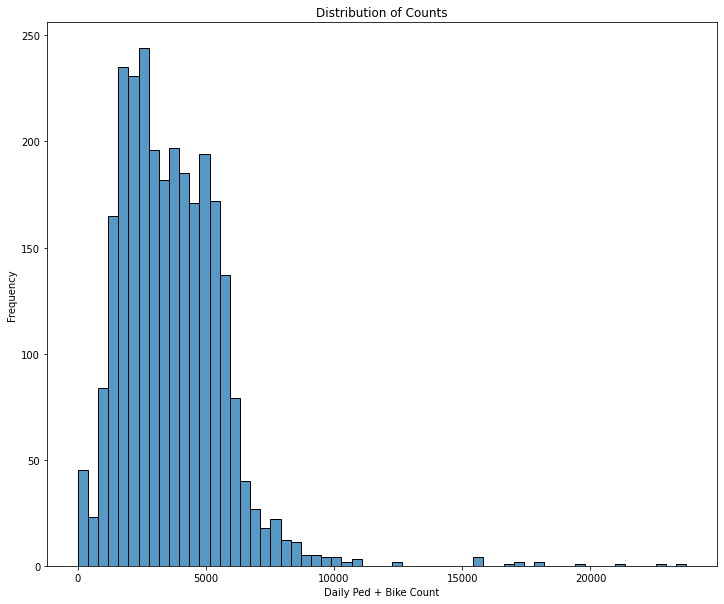

In [ ]:
plt.figure(figsize=(width, height))

ax1 = sns.histplot(data=df['count'], stat='count', bins=60)

plt.title('Distribution of Counts')
plt.xlabel('Daily Ped + Bike Count')
plt.ylabel('Frequency')

plt.show()
plt.close()

This distribution is fairly normal-looking, except for the obvious outliers to the right.

##Dealing with Outliers

There are some extreme outliers here, and I'm not going to be able to make a good model as long as they are there. I suspect they are not mistakes, though, so it's not really right to just remove them. I think there was likely a special event that day that caused numbers to jump. But building a model that accounts for any special event is going to be tough. Let's see if we can understand these outliers a bit more.

In [ ]:
df['count'].describe()

count     2708.000000
mean      3669.436484
std       2074.585832
min          0.000000
25%       2194.500000
50%       3462.000000
75%       4918.250000
max      23740.000000
Name: count, dtype: float64

A common way to define outliers is values more than 3 standard deviations above the mean. Based on the above, this would be any value over about 10,000, which sounds about right given the graph above. I build an array of the rows with z-scores over 3. 

In [ ]:
z_array = scipy.stats.zscore(df['count'])
z_array
outliers = np.where(z_array>3)
outliers = list(outliers)
outliers


[array([], dtype=int64)]

This array is hard to work with; I want it in a list.

In [ ]:
output = [item for t in outliers for item in t]


Now these numbers refer to the sequence of the value in the long list of dates, so they don't mean much until I can associate the data with them.

In [ ]:
df.iloc[output]

,count,high temperature,precipitation


I notice that many of these outliers are occurring in the same week of August for several years in a row. Was this a special event? I googled one of the date ranges: "August 16-18, 2019, Myrtle Edwards Park." I got my answer clear as day - it was the week of Seattle's annual tribute to cannabis, [Hempfest](http://www.hempfest.org/about/seattle-hempfest-2/), which happens in the park. It figures!

## Incorporating Other Variables

I am going to incorporate a variable "Hempfest" because the festival has such a big influence on bike and ped counts on the days it's held. 

I look up the dates that the festival has been held since 2014. 

In [ ]:
Hempfestlist=pd.DatetimeIndex(['2014-08-15', '2014-08-16', '2014-08-17', '2015-08-14', '2015-08-15', '2015-08-16', '2016-08-19', '2016-08-20', '2016-08-21', '2017-08-18', '2017-08-19', '2017-08-20', '2018-08-17', '2018-08-18', '2018-08-19', '2019-08-16', '2019-08-15', '2019-08-14']) 
Hempfestlist

DatetimeIndex(['2014-08-15', '2014-08-16', '2014-08-17', '2015-08-14',
               '2015-08-15', '2015-08-16', '2016-08-19', '2016-08-20',
               '2016-08-21', '2017-08-18', '2017-08-19', '2017-08-20',
               '2018-08-17', '2018-08-18', '2018-08-19', '2019-08-16',
               '2019-08-15', '2019-08-14'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
start = df.index.min()
end = df.index.max()
dr = pd.date_range(start, end)
df['Hempfest'] = dr.isin(Hempfestlist).astype(int)
df.head()

,count,high temperature,precipitation,Hempfest
2014-01-01,2190.0,45.0,0.00,0
2014-01-02,1580.0,51.0,0.16,0
2014-01-03,2469.0,48.0,0.06,0
2014-01-04,3337.0,46.0,0.00,0
2014-01-05,2849.0,47.0,0.00,0


That should help a lot, so I'm going to leave outliers alone for now. There are a couple other variables that I need to account for here which I expect to have an influence on some of the regular variation. First, was it a weekend or not? I would expect parks to be much more crowded on weekends.

In [ ]:
df['Is Weekend?'] = ((pd.DatetimeIndex(df.index).dayofweek) // 5 == 1).astype(int)
df.head()

,count,high temperature,precipitation,Hempfest,Is Weekend?
2014-01-01,2190.0,45.0,0.00,0,0
2014-01-02,1580.0,51.0,0.16,0,0
2014-01-03,2469.0,48.0,0.06,0,0
2014-01-04,3337.0,46.0,0.00,0,1
2014-01-05,2849.0,47.0,0.00,0,1


And on holidays:

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [ ]:
start = df.index.min()
end = df.index.max()
dr = pd.date_range(start, end)
cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

df['Is Holiday?'] = dr.isin(holidays).astype(int)
df

,count,high temperature,precipitation,Hempfest,Is Weekend?,Is Holiday?
2014-01-01,2190.0,45.0,0.00,0,0,1
2014-01-02,1580.0,51.0,0.16,0,0,0
2014-01-03,2469.0,48.0,0.06,0,0,0
2014-01-04,3337.0,46.0,0.00,0,1,0
2014-01-05,2849.0,47.0,0.00,0,1,0
...,...,...,...,...,...,...
2021-06-26,NaN,102.0,0.00,0,1,0
2021-06-27,NaN,104.0,0.00,0,1,0
2021-06-28,NaN,108.0,0.00,0,0,0
2021-06-29,NaN,85.0,0.00,0,0,0


Let's make sure it looks like we got all the holidays:

In [ ]:
df['Is Holiday?'].value_counts()

0    2664
1      74
Name: Is Holiday?, dtype: int64

Now let's combine these two columns into a single variable showing if it is a weekend or a holiday, or neither. 

In [ ]:
df['Weekend or Holiday?'] = ((df['Is Weekend?'] + df['Is Holiday?']) >= 1).astype(int)
df = df.drop(['Is Weekend?', 'Is Holiday?'], axis=1)
df

,count,high temperature,precipitation,Hempfest,Weekend or Holiday?
2014-01-01,2190.0,45.0,0.00,0,1
2014-01-02,1580.0,51.0,0.16,0,0
2014-01-03,2469.0,48.0,0.06,0,0
2014-01-04,3337.0,46.0,0.00,0,1
2014-01-05,2849.0,47.0,0.00,0,1
...,...,...,...,...,...
2021-06-26,NaN,102.0,0.00,0,1
2021-06-27,NaN,104.0,0.00,0,1
2021-06-28,NaN,108.0,0.00,0,0
2021-06-29,NaN,85.0,0.00,0,0


Let's also look at data during the pandemic to see if stay at home orders caused more people to seek solace in parks. I add a variable for "during pandemic?" or not, using a (somewhat subjective) estimation for when the pandemic really took hold.

In [ ]:
date = df.index
pandemic_onset = pd.to_datetime('2020-03-08')
df['During Pandemic?'] = (date >= pandemic_onset).astype(int)
df

,count,high temperature,precipitation,Hempfest,Weekend or Holiday?,During Pandemic?
2014-01-01,2190.0,45.0,0.00,0,1,0
2014-01-02,1580.0,51.0,0.16,0,0,0
2014-01-03,2469.0,48.0,0.06,0,0,0
2014-01-04,3337.0,46.0,0.00,0,1,0
2014-01-05,2849.0,47.0,0.00,0,1,0
...,...,...,...,...,...,...
2021-06-26,NaN,102.0,0.00,0,1,1
2021-06-27,NaN,104.0,0.00,0,1,1
2021-06-28,NaN,108.0,0.00,0,0,1
2021-06-29,NaN,85.0,0.00,0,0,1


##Putting it All Together

Let's evaluate this dataframe to see if we have any missing data. We will be limited in how much analysis we can do if data is missing.

In [ ]:
missing_data = df.isnull()
missing_data.head()

,count,high temperature,precipitation,Hempfest,Weekend or Holiday?,During Pandemic?
2014-01-01,False,False,False,False,False,False
2014-01-02,False,False,False,False,False,False
2014-01-03,False,False,False,False,False,False
2014-01-04,False,False,False,False,False,False
2014-01-05,False,False,False,False,False,False


In [ ]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")  

count
False    2708
True       30
Name: count, dtype: int64

high temperature
False    2737
True        1
Name: high temperature, dtype: int64

precipitation
False    2737
True        1
Name: precipitation, dtype: int64

Hempfest
False    2738
Name: Hempfest, dtype: int64

Weekend or Holiday?
False    2738
Name: Weekend or Holiday?, dtype: int64

During Pandemic?
False    2738
Name: During Pandemic?, dtype: int64



We can see here that (at least at the time of writing) there are a few dates missing a count value, 1 date missing temperature, and 1 date missing precipitation. Let's start with count since it has the most NaN values. There are many ways to deal with this missing data. In some instances I could replace these NaN values with the average count. But since count is my target - what I'm trying to predict - that doesn't seem like a good idea. The NaN values account for less 1% of my total dataset. Therefore, I could just remove these records.

But wait - let's make sure that these missing count values don't just fall at the end of the dataset because the API hasn't updated yet. If I look at the last 30 rows, that should be enough to show if all 24 missing temperatures are at the end.

In [ ]:
df.tail(30)

,count,high temperature,precipitation,Hempfest,Weekend or Holiday?,During Pandemic?
2021-06-01,NaN,86.0,0.00,0,0,1
2021-06-02,NaN,85.0,0.00,0,0,1
2021-06-03,NaN,75.0,0.00,0,0,1
2021-06-04,NaN,68.0,0.00,0,0,1
2021-06-05,NaN,66.0,0.00,0,1,1
2021-06-06,NaN,55.0,0.35,0,1,1
2021-06-07,NaN,63.0,0.11,0,0,1
2021-06-08,NaN,69.0,0.01,0,0,1
2021-06-09,NaN,68.0,0.00,0,0,1
2021-06-10,NaN,65.0,0.00,0,0,1


They are! In fact, this reminds me that the count data API only refreshes monthly and it looks like the NOAA data is a couple days behind. But that's ok, because I can exclude that data for now, but when I re-run this code in a future month, it will have updated.

In [ ]:
df.dropna(subset=['count'], axis=0, inplace=True)
df.dropna(subset=['high temperature'], axis=0, inplace=True)
df.dropna(subset=['precipitation'], axis=0, inplace=True)

Now let's be sure that we took care of all our NaN values.

In [ ]:
missing_data = df.isnull()
missing_data.tail()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")  

count
False    2708
Name: count, dtype: int64

high temperature
False    2708
Name: high temperature, dtype: int64

precipitation
False    2708
Name: precipitation, dtype: int64

Hempfest
False    2708
Name: Hempfest, dtype: int64

Weekend or Holiday?
False    2708
Name: Weekend or Holiday?, dtype: int64

During Pandemic?
False    2708
Name: During Pandemic?, dtype: int64



no values are marked "True," which would mean they were null values in this case, so we're good to go.

## Descriptive Statistics

Now let's run some basic stats to understand how counts are distributed based on these different variables. It will help me know what to expect when I run a regression. 

In [ ]:
df.describe()

,count,high temperature,precipitation,Hempfest,Weekend or Holiday?,During Pandemic?
count,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000
mean,3669.436484,61.761817,0.116507,0.006647,0.313146,0.166174
std,2074.585832,13.099480,0.260973,0.081273,0.463859,0.372306
min,0.000000,29.000000,0.000000,0.000000,0.000000,0.000000
25%,2194.500000,51.000000,0.000000,0.000000,0.000000,0.000000
50%,3462.000000,60.000000,0.000000,0.000000,0.000000,0.000000
75%,4918.250000,72.000000,0.110000,0.000000,1.000000,0.000000
max,23740.000000,98.000000,3.250000,1.000000,1.000000,1.000000


At this point I might choose to standardize the variables to make them all on the same scale. I can see here that ``Temperature`` is on a very different scale than ``count`` which is different than the 1/0 binary scale that ``Weekend or Holiday?`` and ``During Pandemic?`` use. While standardizing might help make the data easier to work with, it should not affect the r-squared value or the relationships between the variables, as I understand. So I am not going to worry about that here, because standardizing might cause the variables to lose meaning when I go to interpret the results. 

##Evaluating the Relationships between Variables

Let's take an initial look at the correlation between some of these variables to see which relationships are worth exploring further.

In [ ]:
df.corr()

,count,high temperature,precipitation,Hempfest,Weekend or Holiday?,During Pandemic?
count,1.000000,0.660293,-0.390282,0.456279,0.005387,0.088211
high temperature,0.660293,1.000000,-0.247088,0.100032,-0.038181,-0.009151
precipitation,-0.390282,-0.247088,1.000000,-0.014928,-0.004021,-0.027139
Hempfest,0.456279,0.100032,-0.014928,1.000000,0.042757,-0.036518
Weekend or Holiday?,0.005387,-0.038181,-0.004021,0.042757,1.000000,-0.001959
During Pandemic?,0.088211,-0.009151,-0.027139,-0.036518,-0.001959,1.000000


First off, I'm surprised that there is no relationship between the count and the 'Weekend or Holiday?' variable. Let's plot this to understand it better:

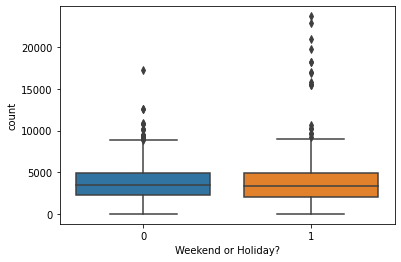

In [ ]:
sns.boxplot(x="Weekend or Holiday?", y="count", data=df)

So while overall there is significant overlap of counts between weekends/holidays and regular weekdays, there are more outliers on the high end during weekends. Therefore, this alone isn't as good a predictor as I would have expected, but we can still explore it when it is combined with another variable like weather. After all, it makes sense to me that if the weather is bad it doesn't much matter what day it is, I'm not likely to go to the park. But if it's Saturday and it's sunny - I bet we'll see something there. We will get to that soon.

Let's do the same boxplot for whether we're in a pandemic or not.

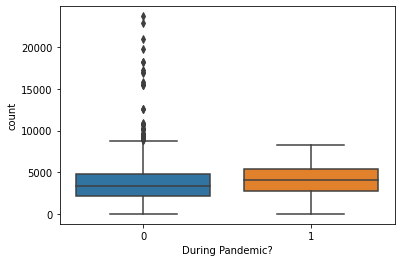

In [ ]:
sns.boxplot(x="During Pandemic?", y="count", data=df)

Again, there's a lot of overlap there, but most of the outliers this time are in pre-pandemic days. Now that we know that those outliers are mostly the Hempfest festival, it makes sense. It wasn't held in person during the pandemic. 

Just to see how satisfying a boxplot can look when there is a lot of variation, let's look at Hempfest days and non-Hempfest days.

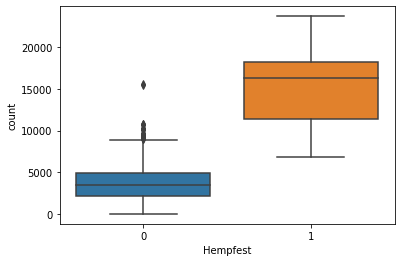

In [ ]:
sns.boxplot(x="Hempfest", y="count", data=df)

Though there are only a handful of datapoints where Hempfest=1 (meaning Hempfest was held that day), the variation is so stark that I can see why the correlation with ``counts`` is so strong.

#Looking at Precipitation a Different Way

I also notice that the relationship between count and precipitation is negative, which makes sense - more rain generally makes people less apt to go outside, even in Seattle. But the relationship is weak, at -.38. I have a hypothesis that it doesn't so much matter *how much* it rains as *whether* it rains that day. In Seattle our *measured annual rainfall* is actually not as high as many other places (including Hawaii), but we have more *days of rain* per year.

So there is another variable in particular that I think would affect bike and pedestrian counts on a given day (based on my own experience): Is it raining? In both cases, I'll want to set up a dummy variable for a yes/no. 

To set a dummy variable for "did it rain today?" I'm going to use the bin feature. First, I'll run a quick histogram and descriptive stats to get a sense of how much rain is typical. 

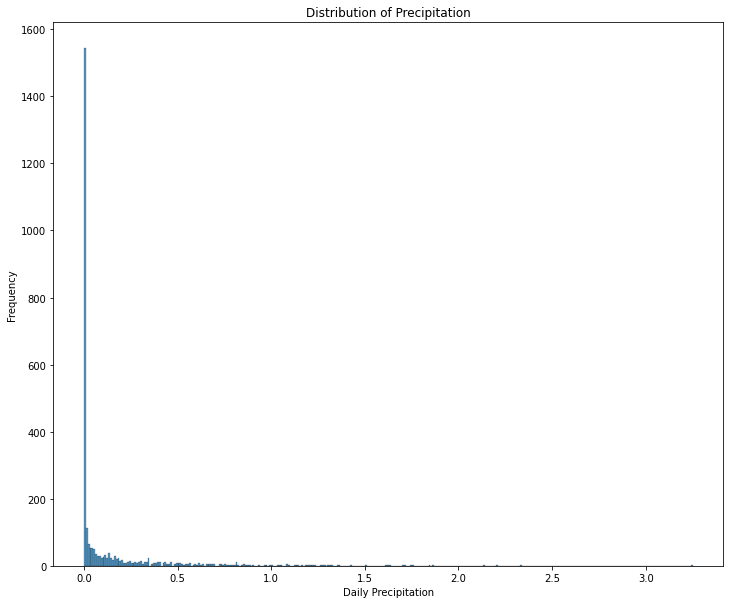

In [ ]:
plt.figure(figsize=(width, height))

ax1 = sns.histplot(data=df['precipitation'], stat='count', binwidth=.01)

plt.title('Distribution of Precipitation')
plt.xlabel('Daily Precipitation')
plt.ylabel('Frequency')

plt.show()
plt.close()

In [ ]:
df['precipitation'].describe()

count    2708.000000
mean        0.116507
std         0.260973
min         0.000000
25%         0.000000
50%         0.000000
75%         0.110000
max         3.250000
Name: precipitation, dtype: float64

Based on this, I'll set all values of 0-0.01 to go into one bin (I'll count that as basically no rain), and all values greater than 0.01 will go into another.

In [ ]:
bins = ([ 0, 0.01, df['precipitation'].max()])

In [ ]:
group_names = ['0', '1']

In [ ]:
rain = pd.cut(df['precipitation'], bins, labels=group_names, include_lowest=True )
df['Did-it-Rain'] = rain
df[['precipitation','Did-it-Rain']].head()

,precipitation,Did-it-Rain
2014-01-01,0.00,0
2014-01-02,0.16,1
2014-01-03,0.06,1
2014-01-04,0.00,0
2014-01-05,0.00,0


In [ ]:
df[["Did-it-Rain"]] = df[["Did-it-Rain"]].astype("float")
df[["Weekend or Holiday?"]] = df[["Weekend or Holiday?"]].astype("float")
df[["During Pandemic?"]] = df[["During Pandemic?"]].astype("float")

In [ ]:
df.head()

,count,high temperature,precipitation,Hempfest,Weekend or Holiday?,During Pandemic?,Did-it-Rain
2014-01-01,2190.0,45.0,0.00,0,1.0,0.0,0.0
2014-01-02,1580.0,51.0,0.16,0,0.0,0.0,1.0
2014-01-03,2469.0,48.0,0.06,0,0.0,0.0,1.0
2014-01-04,3337.0,46.0,0.00,0,1.0,0.0,0.0
2014-01-05,2849.0,47.0,0.00,0,1.0,0.0,0.0


In [ ]:
df.corr()

,count,high temperature,precipitation,Hempfest,Weekend or Holiday?,During Pandemic?,Did-it-Rain
count,1.000000,0.660293,-0.390282,0.456279,0.005387,0.088211,-0.501618
high temperature,0.660293,1.000000,-0.247088,0.100032,-0.038181,-0.009151,-0.409762
precipitation,-0.390282,-0.247088,1.000000,-0.014928,-0.004021,-0.027139,0.556966
Hempfest,0.456279,0.100032,-0.014928,1.000000,0.042757,-0.036518,-0.046551
Weekend or Holiday?,0.005387,-0.038181,-0.004021,0.042757,1.000000,-0.001959,0.014001
During Pandemic?,0.088211,-0.009151,-0.027139,-0.036518,-0.001959,1.000000,-0.013872
Did-it-Rain,-0.501618,-0.409762,0.556966,-0.046551,0.014001,-0.013872,1.000000


And here we go - as I epxected, ``Did-it-Rain`` has a stronger correlation with ``count`` than ``precipitation`` does. Let's look at the distribution of ``count`` on days when it did and did not rain.

In [ ]:
df_grouptest = df[['Did-it-Rain','count']]
grouped_test1 = df_grouptest.groupby(['Did-it-Rain'],as_index=False).mean()

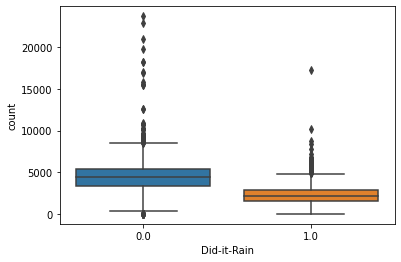

In [ ]:
sns.boxplot(x="Did-it-Rain", y="count", data=df)

Now we're getting somewhere, as we can see a real difference here. 

In [ ]:
df['Did-it-Rain'].value_counts()

0.0    1656
1.0    1052
Name: Did-it-Rain, dtype: int64

lm2 = LinearRegression()
var = df[['normalized-losses','highway-mpg']]
lm2.fit(var, df['price'])
more in lesson 4 lab

#Strength of Relationship

Turning back to our correlation table, we see the strongest relationship is between temperature and count. Is it statistically significant?

In [ ]:
pearson_coef, p_value = stats.pearsonr(df['count'], df['high temperature'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.6602926813720086  with a P-value of P = 0.0


The p-value is 0, showing that the relationship between temperature and count is statistically significant and about as certain as we can be. The strength of the relationship is only moderate, with the correlation coefficient of .66. Now let's do a simple linear regression and look at this on a graph.

## Fitting a Model: Linear Regression

Now comes the fun part, where we try to find a model that will predict ``count`` on any given day.

(0.0, 24927.0)

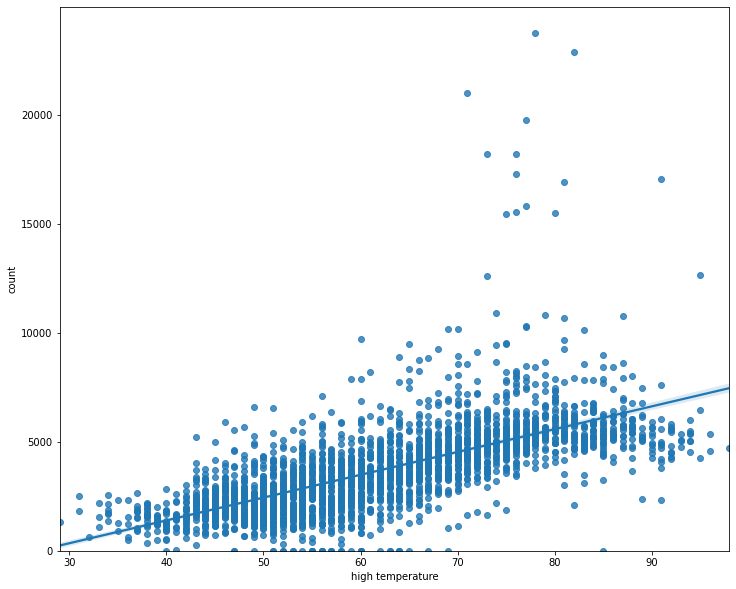

In [ ]:
width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(x="high temperature", y="count", data=df)
plt.ylim(0,)

In [ ]:
lm = LinearRegression()
x = df[['high temperature']]
y = df[['count']]
lm.fit(x, y)
lm.score(x, y)

0.43598642507343677

This shows that there is indeed a positive relationship between temperature and count, though with an r-squared of .43, the relationship is not too strong. 

I also notice that counts seem to drop off a bit when the temperature exceeds about 85 degrees. This is not surprising; Seattleites do not tend to enjoy what we consider "extreme" temperatures (having spent five years in the New York City area, I know this is laughable). This suggests though that a linear regression model might not be the best fit for this data. To be sure, though, let's do a graph of the residuals. 

A residual graph has a dot for each datapoint in the analysis. Each dot shows how far the predicted value was from the actual value. A perfect model then would have a residual graph that is just a straight line at y=0 across the whole graph. The further points are from zero, the more variation there is in the data that is not explained by the model. And if points are mostly on one side of zero, that would tell us that the model consistently over or underpredicts values, so it may not be the best model for this dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



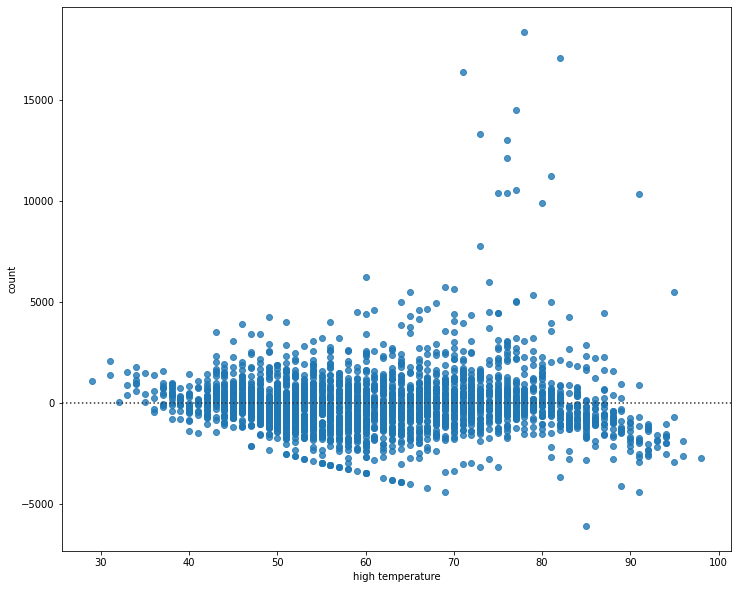

In [ ]:
plt.figure(figsize=(width, height))
sns.residplot(df['high temperature'], df['count'])
plt.show()

This is not too bad, because residuals are distributed fairly evenly between positive and negative, showing that a linear model works fairly well. It starts to break down at those high temperatures at the right where the actual values are mostly all less than the predicted values, so it's possible that a polynomial model could increase accuracy. At the lowest temperatures, conversely, we see that the model underpredicted. (It could be because when it gets that cold in Seattle it usually means it's sunny, or snowing, both of which are more appealing than gray.) 

Also, the residuals are large, reinforcing the fact that there are other variables at play here that we should account for. 

## Multiple Linear Regression

So far we've just looked at the relationship of pairs of variables. We might get more insight if we do a multivariate regression. After playing around a little and removing a couple variables that surprisingly had no effect on the r-squared, I'm running a multiple linear regression using just four variables.

In [ ]:
lm2 = LinearRegression()
targets = df[['high temperature', 'precipitation', 'Did-it-Rain', 'Hempfest']] #'Weekend or Holiday?', 'During Pandemic?',
lm2.fit(targets, df['count'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

This fits a multiple regression model with the following coefficients for each of the five variables named above: 

In [ ]:
lm2.coef_

array([   79.92107163, -1218.34656531,  -813.25998859, 10073.03021618])

And this y-intercept, which of course can't actually happen in the real world:

In [ ]:
lm2.intercept_

-875.7096918385419

Now let's evaluate how well this model fits. 

In [ ]:
#get r-squared of multivariate regression model.
lm2.score(targets, df['count'])

0.6689420362389418

The r-squared is still not as high as I would have hoped with so many variables, but merely by adding ``Hempfest`` I increased it from .52 to .67. Let's dig in a bit more to understand when the model is working and when it's not. 

Interestingly, the r-squared did not change when I included ``Weekend or Holiday`` or ``During Pandemic`` , so I'm keeping those out.

In [ ]:
Y_hat = lm2.predict(targets)

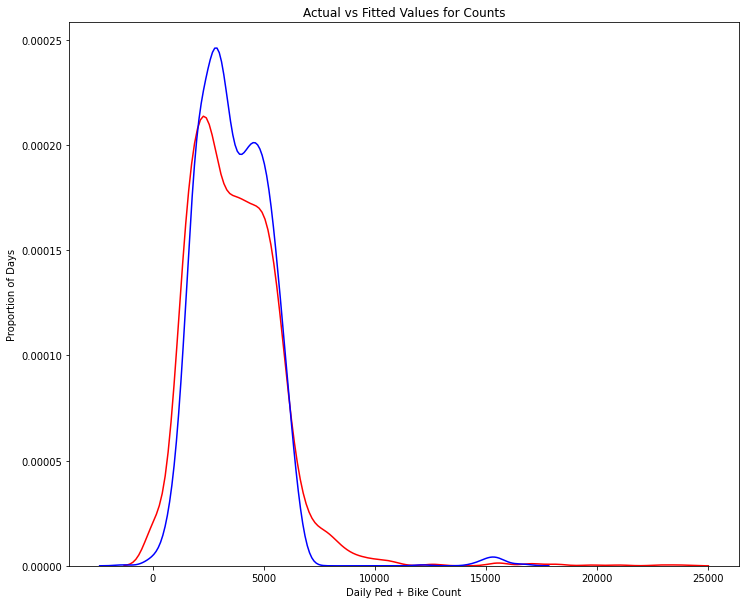

In [ ]:
plt.figure(figsize=(width, height))

ax1 = sns.kdeplot(data = df['count'], color="r", label="Actual Values")
sns.kdeplot(data = Y_hat, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for Counts')
plt.xlabel('Daily Ped + Bike Count')
plt.ylabel('Proportion of Days')

plt.show()
plt.close()

So there is still some work to be done here. The fitted values, in blue, tend to underestimate days with very high counts while overestimating days with medium counts. Some of those medium count days are ones with very high temperatures where the model expects ``count`` to increase accordingly, but where people are actually less likely to venture out. 

The challenge, then, is to figure out what else drives the days with high counts and determine why the model is more likely to predict medium counts even when that's not accurate.

#Polynomial Regression

The plot of residuals above showed there might not be a simple linear relationship between all the variables, particularly ``temperature`` and ``count``. It seems that there is an ideal temperature when people like to go outside, but above that point people are less likely to go. Can we account for that with a polynomial?

In [ ]:
#check accuracy of the below.

In [ ]:
def PlotPolly(model, independent_variable, dependent_variable, Name):
    x_new = np.linspace(25, 95, 100)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variable, '.', x_new, y_new, '-')
    plt.title('Polynomial Fit with Matplotlib for Count ~ Temperature')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel('Count')

    plt.show()
    plt.close()

Here I try a second-order polynomial (meaning an exponent of two is involved)

In [ ]:
x = df['high temperature']
y = df['count']
f = np.polyfit(x, y, 2)
p2 = np.poly1d(f)
print(p2)

        2
-0.129 x + 121 x - 3291


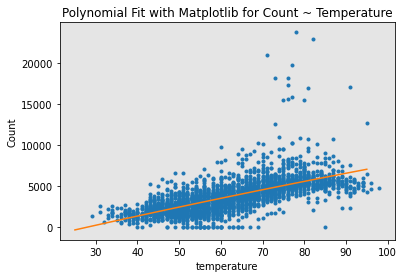

In [ ]:
PlotPolly(p2, x, y, 'temperature')

In [ ]:
r2_score(y, p2(x))

0.4361280393857049

This has not increased my r-squared value compared to the linear model. Let's try a third-order polynomial too:

         3        2
-0.1007 x + 19.2 x - 1076 x + 2.061e+04


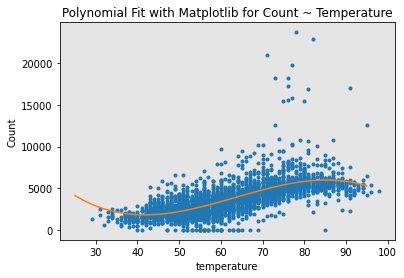

In [ ]:
f3 = np.polyfit(x, y, 3)
p3 = np.poly1d(f3)
print(p3)
PlotPolly(p3, x, y, 'temperature')

In [ ]:
r2_score(y, p3(x))

0.4605450391588989

This increased the r-squared only slightly. It looks like it did a better job of accounting for the slight dip at higher temperatures, but does nothing for the outliers and might be worse at lower temperatures. I tried several higher-order polynomials as well, but it did nothing for the r-squared, so I don't need to list them all here. The point seems to be that temperature only goes so far in explaining the variation in daily counts.

Ideally, a multivariate polynomial regression might be the best model here, but it is beyond what I am comfortable doing at this point. For now, the best model that I have found is the multiple linear regression model.

#Wrap Up

In [ ]:
#%%timeit cell magic to time functions, for my own learning. 
#test for skewness and kurtosis - p 258
#weekend/holiday has low correlation with count. Should i exclude it?
# color 2020 differently in scatterplot; 
#groupby() can analyze stats by category and subcategory. could use for temp categories, and Did It Rain. or compare mean counts for various temp categories.


#ctrl+shift+L : allows you to edit all highlighted items at the same time